# Margining Assignment - schlanke Finalversion

Dieses Notebook deckt **nur** den geforderten Assignment-Umfang ab:
- IM-Herleitung
- Baseline (exogener Default)
- Augmented (Limited Liquidity + Fire Sales, inkl. IM-Funding)
- Risiko-Metriken und Default-Statistiken
- Policy-Vergleiche (a-d)
- minimaler Prozyklizitaets-Check

Alle Simulationen sind reproduzierbar ueber `np.random.default_rng(seed)`.


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from statistics import NormalDist

# Clean defaults (Assignment scope)
params = {
    "N": 6000,
    "T_sim": 252,
    "S0": 100.0,
    "K": 100.0,
    "Q": 100.0,
    "sigma_s": 0.30,
    "MPOR": 10,
    "PD_annual": 0.20,
    "seed": 42,
    "IM_conf": 0.99,
    "IM_mult": 1.0,
    "VM_freq": 1,
    "L0": 400.0,
    "A0": 600.0,
    "h": 0.15,
}

params


{'N': 6000,
 'T_sim': 252,
 'S0': 100.0,
 'K': 100.0,
 'Q': 100.0,
 'sigma_s': 0.3,
 'MPOR': 10,
 'PD_annual': 0.2,
 'seed': 42,
 'IM_conf': 0.99,
 'IM_mult': 1.0,
 'VM_freq': 1,
 'L0': 400.0,
 'A0': 600.0,
 'h': 0.15}

## A) Theoretische Herleitung von IM

Forward-MTM aus Sicht Investor A (long forward):

\[
V_t = Q\,(S_t - K)
\]

Unter daily Inkrementen ohne Drift:

\[
S_{t+\Delta} - S_t \sim \mathcal{N}(0,\,\Delta\,\sigma_s^2)
\]

Daraus folgt:

\[
\Delta V = Q\,(S_{t+\Delta} - S_t) \sim \mathcal{N}(0,\,Q^2\,\Delta\,\sigma_s^2)
\]

One-sided 99%-VaR ueber MPOR:

\[
IM = z_{0.99}\,|Q|\,\sigma_s\,\sqrt{MPOR}
\]

mit \(z_{0.99} pprox 2.326\), im Code via `NormalDist().inv_cdf(0.99)`.


In [76]:
def annual_pd_to_daily(PD_annual: float, days: int = 252) -> float:
    lam = -log(1.0 - PD_annual)
    return 1.0 - np.exp(-lam / days)


def compute_im(Q: float, sigma_s: float, MPOR: int, conf: float, mult: float = 1.0) -> float:
    z = NormalDist().inv_cdf(conf)
    return mult * z * abs(Q) * sigma_s * sqrt(MPOR)


z_99 = NormalDist().inv_cdf(0.99)
print(f"z_0.99 = {z_99:.3f}")


z_0.99 = 2.326


## B) Simulation von Preis- und MTM-Pfaden

Wir simulieren `N` additive Preis-Pfade ohne Drift mit daily Volatilitaet `sigma_s`.
Danach berechnen wir das MTM entlang jedes Pfads mit

\[
V_t = Q\,(S_t - K)
\]

Die Pfade laufen bis `T_sim + MPOR`, damit Closeout-Indizes sicher sind.


In [77]:
def simulate_market_paths(N: int, T_sim: int, MPOR: int, S0: float, K: float, Q: float,
                          sigma_s: float, seed: int):
    total_days = T_sim + MPOR
    rng = np.random.default_rng(seed)

    dS = rng.normal(0.0, sigma_s, size=(N, total_days))
    S = np.zeros((N, total_days + 1), dtype=float)
    S[:, 0] = S0
    S[:, 1:] = S0 + np.cumsum(dS, axis=1)

    V = Q * (S - K)
    return S, V


## C) Baseline-Modell (exogener Default)

Sign-Conventions (A-Sicht):
- `V_t > 0`: B schuldet A.
- `V_t < 0`: A schuldet B.
- `vm_transfer = V_t - V_last_settled`
  - `< 0`: A muss VM an B posten
  - `> 0`: A erhaelt VM von B

Im Baseline-Modell hat A unbegrenzte Liquiditaet. VM wird ueber `last_settled_mtm` repraesentiert.
Bei Default in `t` stoppt VM bis Closeout `t_close = min(t + MPOR, T_sim)`.

Hinweis aus `Assignment.ipynb`: Dort wurde dieselbe Logik auch ueber ein explizites `vm_account` beschrieben (Collateral-Puffer aus bereits geposteter VM). In dieser schlanken Version wird dieser Puffer ueber `last_settled_mtm` repraesentiert, was mathematisch zur gleichen Loss-Idee fuehrt.


In [78]:
def run_baseline_exogenous(V, p_day, IM, T_sim, MPOR, VM_freq, seed):
    rng = np.random.default_rng(seed + 1000)
    N = V.shape[0]

    losses = np.zeros(N)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, np.nan)
    default_type = np.array([None] * N, dtype=object)
    fire_sale_cost = np.zeros(N)
    fire_sale_events = np.zeros(N, dtype=int)

    for i in range(N):
        last_settled_mtm = V[i, 0]

        for t in range(1, T_sim + 1):
            # Default first: no VM from t to t+MPOR
            if rng.random() < p_day:
                default_flag[i] = True
                default_day[i] = t
                default_type[i] = "exogenous"

                t_close = min(t + MPOR, T_sim)
                V_close = V[i, t_close]

                amount_owed_to_B = max(0.0, -V_close)
                last_VM_held_by_B = max(0.0, -last_settled_mtm)
                collateral_available = IM + last_VM_held_by_B

                losses[i] = max(0.0, amount_owed_to_B - collateral_available)
                break

            if t % VM_freq == 0:
                last_settled_mtm = V[i, t]

    return {
        "losses": losses,
        "default_flag": default_flag,
        "default_day": default_day,
        "default_type": default_type,
        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,
    }


## D) Augmented-Modell (Limited Liquidity + Fire Sales)

A startet mit Cash `L0` und illiquiden Assets `A0`.
Wichtig: **IM wird bei t=0 wirklich finanziert/gepostet**.

Wenn A zahlen muss (IM/VM):
- erst Cash,
- dann (cash-only Policy): Fire Sale mit Haircut `h`,
- oder (Policy d) `allow_illiquid_collateral=True`: illiquides Collateral direkt posten (kein Haircut, keine Fire-Sale-Kosten).

Bei Liquiditaetsdefault gilt derselbe Closeout-Loss-Mechanismus wie im Baseline-Modell.


In [79]:
def run_augmented_liquidity(V, p_day, IM, T_sim, MPOR, VM_freq,
                            L0, A0, h, seed,
                            allow_illiquid_collateral=False):
    rng = np.random.default_rng(seed + 2000)
    N = V.shape[0]

    losses = np.zeros(N)
    default_flag = np.zeros(N, dtype=bool)
    default_day = np.full(N, np.nan)
    default_type = np.array([None] * N, dtype=object)
    fire_sale_cost = np.zeros(N)
    fire_sale_events = np.zeros(N, dtype=int)

    for i in range(N):
        cash = float(L0)
        illiquid = float(A0)
        im_posted = 0.0
        last_settled_mtm = V[i, 0]

        # --- IM funding at t=0 ---
        if IM <= cash:
            cash -= IM
            im_posted = IM
        else:
            shortfall_im = IM - cash
            im_posted = cash

            if allow_illiquid_collateral:
                if shortfall_im <= illiquid:
                    illiquid -= shortfall_im
                    im_posted = IM
                    cash = 0.0
                else:
                    default_flag[i] = True
                    default_day[i] = 0
                    default_type[i] = "liquidity"
            else:
                sale_nominal = shortfall_im / (1.0 - h)
                if sale_nominal <= illiquid:
                    illiquid -= sale_nominal
                    fire_sale_cost[i] += h * sale_nominal
                    fire_sale_events[i] += 1
                    im_posted = IM
                    cash = 0.0
                else:
                    default_flag[i] = True
                    default_day[i] = 0
                    default_type[i] = "liquidity"

        if default_flag[i]:
            t_close = min(MPOR, T_sim)
            V_close = V[i, t_close]
            amount_owed_to_B = max(0.0, -V_close)
            last_VM_held_by_B = max(0.0, -last_settled_mtm)
            collateral_available = im_posted + last_VM_held_by_B
            losses[i] = max(0.0, amount_owed_to_B - collateral_available)
            continue

        # --- Daily loop ---
        for t in range(1, T_sim + 1):
            if rng.random() < p_day:
                default_flag[i] = True
                default_day[i] = t
                default_type[i] = "exogenous"

                t_close = min(t + MPOR, T_sim)
                V_close = V[i, t_close]
                amount_owed_to_B = max(0.0, -V_close)
                last_VM_held_by_B = max(0.0, -last_settled_mtm)
                collateral_available = im_posted + last_VM_held_by_B
                losses[i] = max(0.0, amount_owed_to_B - collateral_available)
                break

            if t % VM_freq == 0:
                vm_transfer = V[i, t] - last_settled_mtm

                if vm_transfer < 0:
                    vm_call = -vm_transfer

                    if vm_call <= cash:
                        cash -= vm_call
                        last_settled_mtm = V[i, t]
                    else:
                        shortfall = vm_call - cash

                        if allow_illiquid_collateral:
                            if shortfall <= illiquid:
                                cash = 0.0
                                illiquid -= shortfall
                                last_settled_mtm = V[i, t]
                            else:
                                default_flag[i] = True
                                default_day[i] = t
                                default_type[i] = "liquidity"
                        else:
                            sale_nominal = shortfall / (1.0 - h)
                            if sale_nominal <= illiquid:
                                cash = 0.0
                                illiquid -= sale_nominal
                                fire_sale_cost[i] += h * sale_nominal
                                fire_sale_events[i] += 1
                                last_settled_mtm = V[i, t]
                            else:
                                default_flag[i] = True
                                default_day[i] = t
                                default_type[i] = "liquidity"

                        if default_flag[i]:
                            t_close = min(t + MPOR, T_sim)
                            V_close = V[i, t_close]
                            amount_owed_to_B = max(0.0, -V_close)
                            last_VM_held_by_B = max(0.0, -last_settled_mtm)
                            collateral_available = im_posted + last_VM_held_by_B
                            losses[i] = max(0.0, amount_owed_to_B - collateral_available)
                            break
                else:
                    cash += vm_transfer
                    last_settled_mtm = V[i, t]

    return {
        "losses": losses,
        "default_flag": default_flag,
        "default_day": default_day,
        "default_type": default_type,
        "fire_sale_cost": fire_sale_cost,
        "fire_sale_events": fire_sale_events,
    }


## E) Risiko-Metriken und Auswertung

Wir berichten:
- Unconditional Distribution (`all losses`)
- Conditional Distribution (`loss > 0`)
- EL, VaR99, ES99
- Default-Raten (exo/liq/total)
- Fire-Sale-Kosten und Fire-Sale-Events (nur augmented relevant)


In [80]:
def risk_metrics(losses, alpha=0.99):
    losses = np.asarray(losses)
    el = float(np.mean(losses))
    var = float(np.quantile(losses, alpha))
    tail = losses[losses >= var]
    es = float(np.mean(tail)) if tail.size > 0 else 0.0
    return el, var, es


def risk_metrics_conditional(losses, alpha=0.99):
    losses = np.asarray(losses)
    pos = losses[losses > 0]
    if pos.size == 0:
        return 0.0, 0.0, 0.0
    return risk_metrics(pos, alpha=alpha)


def summarize_output(scenario_name, model, out, alpha=0.99, extras=None):
    el, var99, es99 = risk_metrics(out["losses"], alpha=alpha)

    row = {
        "scenario_name": scenario_name,
        "model": model,
        "EL": el,
        "VaR99": var99,
        "ES99": es99,
        "default_rate_total": float(np.mean(out["default_flag"])),
        "default_rate_exo": float(np.mean(out["default_type"] == "exogenous")),
        "default_rate_liq": float(np.mean(out["default_type"] == "liquidity")),
        "mean_fire_sale_cost": float(np.mean(out["fire_sale_cost"])),
        "mean_fire_sale_events": float(np.mean(out["fire_sale_events"])),
    }

    if extras:
        row.update(extras)
    return row


## Baseline- und Augmented-Run (Hauptlauf)

Ein Baseline- und ein Augmented-Lauf mit den Default-Parametern.
Danach folgen Tabellen plus zwei Histogramme (unconditional / conditional).


In [81]:
p_day = annual_pd_to_daily(params["PD_annual"])
IM = compute_im(
    Q=params["Q"],
    sigma_s=params["sigma_s"],
    MPOR=params["MPOR"],
    conf=params["IM_conf"],
    mult=params["IM_mult"],
)

S, V = simulate_market_paths(
    N=params["N"],
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    S0=params["S0"],
    K=params["K"],
    Q=params["Q"],
    sigma_s=params["sigma_s"],
    seed=params["seed"],
)

baseline = run_baseline_exogenous(
    V=V,
    p_day=p_day,
    IM=IM,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    seed=params["seed"],
)

augmented = run_augmented_liquidity(
    V=V,
    p_day=p_day,
    IM=IM,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    L0=params["L0"],
    A0=params["A0"],
    h=params["h"],
    seed=params["seed"],
    allow_illiquid_collateral=False,
)

main_summary = pd.DataFrame([
    summarize_output("base", "baseline", baseline),
    summarize_output("base", "augmented", augmented),
])

dist_rows = []
for model_name, out in [("baseline", baseline), ("augmented", augmented)]:
    el_u, var_u, es_u = risk_metrics(out["losses"])
    el_c, var_c, es_c = risk_metrics_conditional(out["losses"])
    dist_rows.append({
        "model": model_name,
        "EL_uncond": el_u,
        "VaR99_uncond": var_u,
        "ES99_uncond": es_u,
        "EL_cond": el_c,
        "VaR99_cond": var_c,
        "ES99_cond": es_c,
    })

distribution_summary = pd.DataFrame(dist_rows)

print(f"Daily p_default = {p_day:.6f}")
print(f"IM level = {IM:.4f}")
print(f"S shape = {S.shape}, V shape = {V.shape}")
print("\nMain summary:")
main_summary


Daily p_default = 0.000885
IM level = 220.6967
S shape = (6000, 263), V shape = (6000, 263)

Main summary:


,scenario_name,model,EL,VaR99,ES99,default_rate_total,default_rate_exo,default_rate_liq,mean_fire_sale_cost,mean_fire_sale_events
0,base,baseline,0.016494,0.0,0.016494,0.195167,0.195167,0.000000,0.000000,0.000
1,base,augmented,0.204112,0.0,0.204112,0.305833,0.190500,0.115333,28.979529,7.889


In [82]:
print("Distribution summary (unconditional + conditional):")
distribution_summary


Distribution summary (unconditional + conditional):


,model,EL_uncond,VaR99_uncond,ES99_uncond,EL_cond,VaR99_cond,ES99_cond
0,baseline,0.016494,0.0,0.016494,24.740693,69.225785,70.853448
1,augmented,0.204112,0.0,0.204112,40.822391,132.506306,139.446499


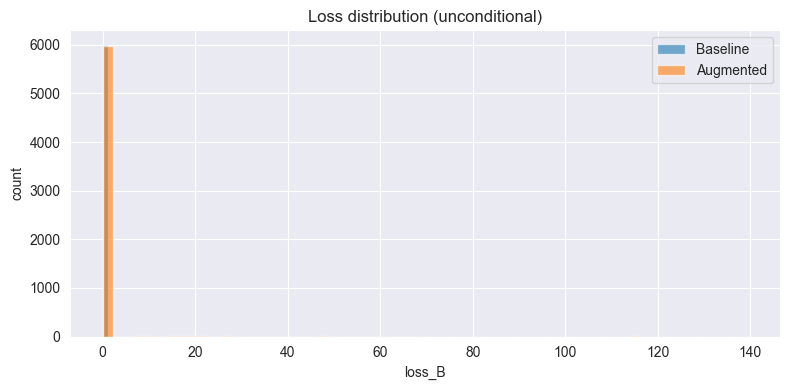

In [83]:
# Histogram 1: unconditional losses
plt.figure(figsize=(8, 4))
plt.hist(baseline["losses"], bins=60, alpha=0.6, label="Baseline")
plt.hist(augmented["losses"], bins=60, alpha=0.6, label="Augmented")
plt.title("Loss distribution (unconditional)")
plt.xlabel("loss_B")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()


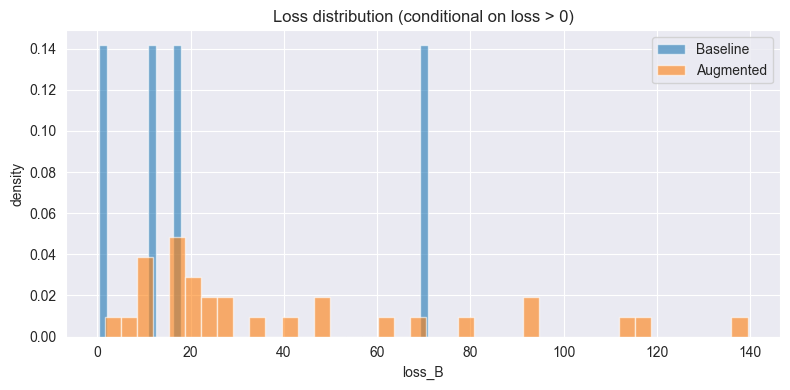

In [84]:
# Histogram 2: conditional losses (loss > 0)
b_pos = baseline["losses"][baseline["losses"] > 0]
a_pos = augmented["losses"][augmented["losses"] > 0]

plt.figure(figsize=(8, 4))
if b_pos.size > 0:
    plt.hist(b_pos, bins=40, alpha=0.6, density=True, label="Baseline")
if a_pos.size > 0:
    plt.hist(a_pos, bins=40, alpha=0.6, density=True, label="Augmented")
plt.title("Loss distribution (conditional on loss > 0)")
plt.xlabel("loss_B")
plt.ylabel("density")
plt.legend()
plt.tight_layout()
plt.show()


## F) Policy proposals (a-d)

Wir halten die Grids klein:
- (a) IM_mult `k in {1.0, 1.5, 2.0}`
- (b) VM_freq `{1, 5}`
- (c) MPOR `{10, 5}`
- (d) Collateral Policy: `cash_only` vs `cash_plus_illiquid_collateral`

Hinweis zu (d): Das erweitert nur die Funding-Option. Das Risiko wird teilweise auf B transferiert,
weil illiquides Collateral marktrisiko-behaftet sein kann (hier nur qualitativ diskutiert, nicht stochastisch modelliert).


In [85]:
def run_policy_scenarios(base_params, N_policy=3000):
    scenario_specs = []

    # (a) IM increase
    for k in [1.0, 1.5, 2.0]:
        scenario_specs.append({
            "scenario_name": f"a_IM_mult_{k}",
            "overrides": {"IM_mult": k},
            "allow_illiquid_collateral": False,
        })

    # (b) daily vs weekly VM
    for freq in [1, 5]:
        scenario_specs.append({
            "scenario_name": f"b_VM_freq_{freq}",
            "overrides": {"VM_freq": freq},
            "allow_illiquid_collateral": False,
        })

    # (c) reduce MPOR
    for mpor in [10, 5]:
        scenario_specs.append({
            "scenario_name": f"c_MPOR_{mpor}",
            "overrides": {"MPOR": mpor},
            "allow_illiquid_collateral": False,
        })

    # (d) collateral expansion
    scenario_specs.append({
        "scenario_name": "d_cash_only",
        "overrides": {},
        "allow_illiquid_collateral": False,
    })
    scenario_specs.append({
        "scenario_name": "d_cash_plus_illiquid_collateral",
        "overrides": {},
        "allow_illiquid_collateral": True,
    })

    rows = []

    for idx, spec in enumerate(scenario_specs):
        cfg = dict(base_params)
        cfg.update(spec["overrides"])

        p_day_local = annual_pd_to_daily(cfg["PD_annual"])
        IM_local = compute_im(
            Q=cfg["Q"],
            sigma_s=cfg["sigma_s"],
            MPOR=cfg["MPOR"],
            conf=cfg["IM_conf"],
            mult=cfg["IM_mult"],
        )

        _, V_local = simulate_market_paths(
            N=N_policy,
            T_sim=cfg["T_sim"],
            MPOR=cfg["MPOR"],
            S0=cfg["S0"],
            K=cfg["K"],
            Q=cfg["Q"],
            sigma_s=cfg["sigma_s"],
            seed=cfg["seed"] + 100 * (idx + 1),
        )

        baseline_local = run_baseline_exogenous(
            V=V_local,
            p_day=p_day_local,
            IM=IM_local,
            T_sim=cfg["T_sim"],
            MPOR=cfg["MPOR"],
            VM_freq=cfg["VM_freq"],
            seed=cfg["seed"] + 100 * (idx + 1),
        )

        augmented_local = run_augmented_liquidity(
            V=V_local,
            p_day=p_day_local,
            IM=IM_local,
            T_sim=cfg["T_sim"],
            MPOR=cfg["MPOR"],
            VM_freq=cfg["VM_freq"],
            L0=cfg["L0"],
            A0=cfg["A0"],
            h=cfg["h"],
            seed=cfg["seed"] + 100 * (idx + 1),
            allow_illiquid_collateral=spec["allow_illiquid_collateral"],
        )

        extras = {
            "IM_mult": cfg["IM_mult"],
            "VM_freq": cfg["VM_freq"],
            "MPOR": cfg["MPOR"],
            "allow_illiquid_collateral": spec["allow_illiquid_collateral"],
            "IM_level": IM_local,
        }

        rows.append(summarize_output(spec["scenario_name"], "baseline", baseline_local, extras=extras))
        rows.append(summarize_output(spec["scenario_name"], "augmented", augmented_local, extras=extras))

    return pd.DataFrame(rows)


policy_summary = run_policy_scenarios(params, N_policy=3000)

policy_summary[[
    "scenario_name", "model", "EL", "VaR99", "ES99",
    "default_rate_total", "default_rate_exo", "default_rate_liq",
    "mean_fire_sale_cost", "mean_fire_sale_events"
]]


,scenario_name,model,EL,VaR99,ES99,default_rate_total,default_rate_exo,default_rate_liq,mean_fire_sale_cost,mean_fire_sale_events
0,a_IM_mult_1.0,baseline,0.062278,0.000000,0.062278,0.194667,0.194667,0.000000,0.000000,0.000000
1,a_IM_mult_1.0,augmented,0.116039,0.000000,0.116039,0.313000,0.188667,0.124333,30.410838,8.191667
2,a_IM_mult_1.5,baseline,0.027531,0.000000,0.027531,0.200333,0.200333,0.000000,0.000000,0.000000
3,a_IM_mult_1.5,augmented,0.052261,0.000000,0.052261,0.366000,0.188000,0.178000,39.373146,10.598333
4,a_IM_mult_2.0,baseline,0.000000,0.000000,0.000000,0.192000,0.192000,0.000000,0.000000,0.000000
5,a_IM_mult_2.0,augmented,0.000000,0.000000,0.000000,0.430000,0.163667,0.266333,53.839382,13.538333
6,b_VM_freq_1,baseline,0.012409,0.000000,0.012409,0.192667,0.192667,0.000000,0.000000,0.000000
7,b_VM_freq_1,augmented,0.195519,0.000000,0.195519,0.317333,0.198000,0.119333,29.146257,7.929667
8,b_VM_freq_5,baseline,0.097611,0.000000,0.097611,0.188333,0.188333,0.000000,0.000000,0.000000
9,b_VM_freq_5,augmented,0.696907,23.438158,64.780861,0.289000,0.179333,0.109667,26.453513,3.263333


In [86]:
# Compact policy views
policy_a = policy_summary[policy_summary["scenario_name"].str.startswith("a_")]
policy_b = policy_summary[policy_summary["scenario_name"].str.startswith("b_")]
policy_c = policy_summary[policy_summary["scenario_name"].str.startswith("c_")]
policy_d = policy_summary[policy_summary["scenario_name"].str.startswith("d_")]

print("Policy (a) IM_mult:")
print(policy_a[["scenario_name", "model", "VaR99", "default_rate_liq", "mean_fire_sale_cost"]].to_string(index=False))
print("\nPolicy (b) VM_freq:")
print(policy_b[["scenario_name", "model", "VaR99", "default_rate_total", "default_rate_liq"]].to_string(index=False))
print("\nPolicy (c) MPOR:")
print(policy_c[["scenario_name", "model", "VaR99", "default_rate_total", "default_rate_liq"]].to_string(index=False))
print("\nPolicy (d) Collateral set:")
print(policy_d[["scenario_name", "model", "VaR99", "default_rate_liq", "mean_fire_sale_cost"]].to_string(index=False))


Policy (a) IM_mult:
scenario_name     model  VaR99  default_rate_liq  mean_fire_sale_cost
a_IM_mult_1.0  baseline    0.0          0.000000             0.000000
a_IM_mult_1.0 augmented    0.0          0.124333            30.410838
a_IM_mult_1.5  baseline    0.0          0.000000             0.000000
a_IM_mult_1.5 augmented    0.0          0.178000            39.373146
a_IM_mult_2.0  baseline    0.0          0.000000             0.000000
a_IM_mult_2.0 augmented    0.0          0.266333            53.839382

Policy (b) VM_freq:
scenario_name     model     VaR99  default_rate_total  default_rate_liq
  b_VM_freq_1  baseline  0.000000            0.192667          0.000000
  b_VM_freq_1 augmented  0.000000            0.317333          0.119333
  b_VM_freq_5  baseline  0.000000            0.188333          0.000000
  b_VM_freq_5 augmented 23.438158            0.289000          0.109667

Policy (c) MPOR:
scenario_name     model  VaR99  default_rate_total  default_rate_liq
    c_MPOR_10  baselin

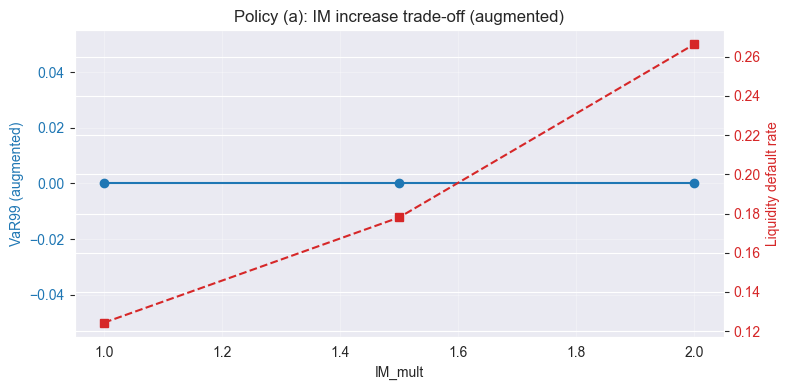

In [87]:
# Policy plot 1: IM_mult trade-off (augmented)
sub_a_aug = policy_a[policy_a["model"] == "augmented"].copy()
sub_a_aug = sub_a_aug.sort_values("IM_mult")

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1.plot(sub_a_aug["IM_mult"], sub_a_aug["VaR99"], marker="o", color="tab:blue", label="VaR99")
ax1.set_xlabel("IM_mult")
ax1.set_ylabel("VaR99 (augmented)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(sub_a_aug["IM_mult"], sub_a_aug["default_rate_liq"], marker="s", ls="--", color="tab:red", label="Liquidity default rate")
ax2.set_ylabel("Liquidity default rate", color="tab:red")
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Policy (a): IM increase trade-off (augmented)")
fig.tight_layout()
plt.show()


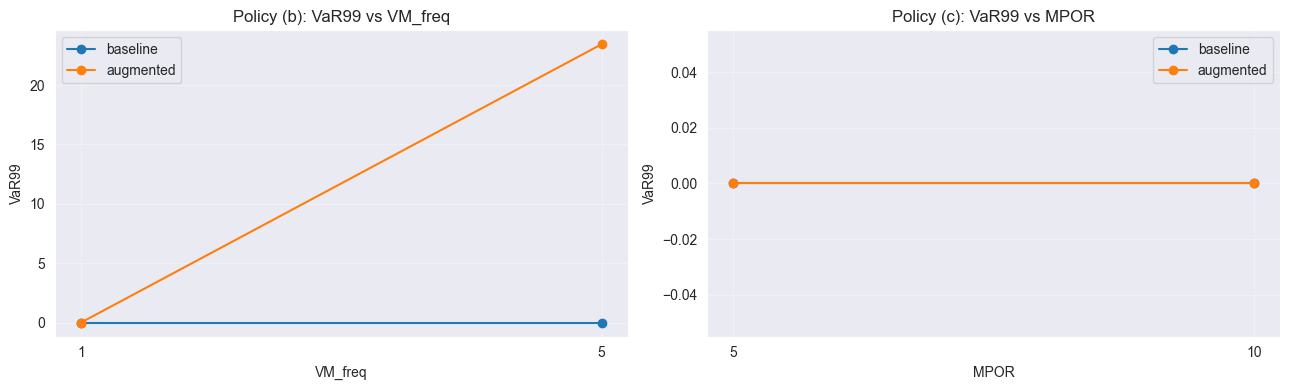

In [88]:
# Policy plot 2: VM_freq and MPOR comparison (baseline vs augmented)
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

sub_b = policy_b.sort_values(["model", "VM_freq"])
for model_name in ["baseline", "augmented"]:
    s = sub_b[sub_b["model"] == model_name].sort_values("VM_freq")
    axes[0].plot(s["VM_freq"], s["VaR99"], marker="o", label=model_name)
axes[0].set_title("Policy (b): VaR99 vs VM_freq")
axes[0].set_xlabel("VM_freq")
axes[0].set_ylabel("VaR99")
axes[0].set_xticks([1, 5])
axes[0].grid(alpha=0.3)
axes[0].legend()

sub_c = policy_c.sort_values(["model", "MPOR"])
for model_name in ["baseline", "augmented"]:
    s = sub_c[sub_c["model"] == model_name].sort_values("MPOR")
    axes[1].plot(s["MPOR"], s["VaR99"], marker="o", label=model_name)
axes[1].set_title("Policy (c): VaR99 vs MPOR")
axes[1].set_xlabel("MPOR")
axes[1].set_ylabel("VaR99")
axes[1].set_xticks([5, 10])
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()


## Zusatz aus `Assignment.ipynb`: Quick-Checks und Kurzinterpretation

Diese kompakte Sektion uebernimmt die Kernaussagen aus dem urspruenglichen `Assignment.ipynb`:
- **Check (a)**: sehr hohes IM sollte Verluste praktisch auf 0 druecken.
- **Check (b)**: weniger haeufiges VM (woechentlich) erhoeht typischerweise Tail-Risiko.
- **Check (c)**: bei fixem IM fuehrt laengeres MPOR zu hoeherem Tail-Risiko.

Damit sind die dortigen "Quick Checks" direkt in der Finalversion dokumentiert.


In [89]:
# Quick checks (kompakt) uebernommen aus Assignment.ipynb
quick_rows = []

# (a) Huge IM check
IM_huge = 1e9
b_huge = run_baseline_exogenous(
    V=V,
    p_day=p_day,
    IM=IM_huge,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    seed=params["seed"],
)
a_huge = run_augmented_liquidity(
    V=V,
    p_day=p_day,
    IM=IM_huge,
    T_sim=params["T_sim"],
    MPOR=params["MPOR"],
    VM_freq=params["VM_freq"],
    L0=params["L0"],
    A0=params["A0"],
    h=params["h"],
    seed=params["seed"],
    allow_illiquid_collateral=False,
)
quick_rows.append({
    "check": "a_huge_IM",
    "model": "baseline",
    "metric": "max_loss",
    "value": float(np.max(b_huge["losses"])),
})
quick_rows.append({
    "check": "a_huge_IM",
    "model": "augmented",
    "metric": "max_loss",
    "value": float(np.max(a_huge["losses"])),
})

# (b) VM daily vs weekly (holding IM fixed)
for freq in [1, 5]:
    b_vm = run_baseline_exogenous(
        V=V,
        p_day=p_day,
        IM=IM,
        T_sim=params["T_sim"],
        MPOR=params["MPOR"],
        VM_freq=freq,
        seed=params["seed"] + freq,
    )
    a_vm = run_augmented_liquidity(
        V=V,
        p_day=p_day,
        IM=IM,
        T_sim=params["T_sim"],
        MPOR=params["MPOR"],
        VM_freq=freq,
        L0=params["L0"],
        A0=params["A0"],
        h=params["h"],
        seed=params["seed"] + freq,
        allow_illiquid_collateral=False,
    )
    quick_rows.append({
        "check": f"b_VM_freq_{freq}",
        "model": "baseline",
        "metric": "VaR99",
        "value": float(np.quantile(b_vm["losses"], 0.99)),
    })
    quick_rows.append({
        "check": f"b_VM_freq_{freq}",
        "model": "augmented",
        "metric": "VaR99",
        "value": float(np.quantile(a_vm["losses"], 0.99)),
    })

# (c) MPOR sensitivity with fixed IM
for mpor in [5, 10]:
    _, V_mpor = simulate_market_paths(
        N=3000,
        T_sim=params["T_sim"],
        MPOR=mpor,
        S0=params["S0"],
        K=params["K"],
        Q=params["Q"],
        sigma_s=params["sigma_s"],
        seed=params["seed"] + 500 + mpor,
    )

    p_day_m = annual_pd_to_daily(params["PD_annual"])

    b_mpor = run_baseline_exogenous(
        V=V_mpor,
        p_day=p_day_m,
        IM=IM,  # fixed IM
        T_sim=params["T_sim"],
        MPOR=mpor,
        VM_freq=params["VM_freq"],
        seed=params["seed"] + 500 + mpor,
    )
    a_mpor = run_augmented_liquidity(
        V=V_mpor,
        p_day=p_day_m,
        IM=IM,  # fixed IM
        T_sim=params["T_sim"],
        MPOR=mpor,
        VM_freq=params["VM_freq"],
        L0=params["L0"],
        A0=params["A0"],
        h=params["h"],
        seed=params["seed"] + 500 + mpor,
        allow_illiquid_collateral=False,
    )

    quick_rows.append({
        "check": f"c_fixedIM_MPOR_{mpor}",
        "model": "baseline",
        "metric": "VaR99",
        "value": float(np.quantile(b_mpor["losses"], 0.99)),
    })
    quick_rows.append({
        "check": f"c_fixedIM_MPOR_{mpor}",
        "model": "augmented",
        "metric": "VaR99",
        "value": float(np.quantile(a_mpor["losses"], 0.99)),
    })

assignment_quick_checks = pd.DataFrame(quick_rows)
assignment_quick_checks


,check,model,metric,value
0,a_huge_IM,baseline,max_loss,0.000000
1,a_huge_IM,augmented,max_loss,0.000000
2,b_VM_freq_1,baseline,VaR99,0.000000
3,b_VM_freq_1,augmented,VaR99,0.000000
4,b_VM_freq_5,baseline,VaR99,0.000000
5,b_VM_freq_5,augmented,VaR99,13.428729
6,c_fixedIM_MPOR_5,baseline,VaR99,0.000000
7,c_fixedIM_MPOR_5,augmented,VaR99,0.000000
8,c_fixedIM_MPOR_10,baseline,VaR99,0.000000
9,c_fixedIM_MPOR_10,augmented,VaR99,0.000000


**Kurzinterpretation (aus den Assignment-Checks):**
- Hoeheres IM reduziert Verluste fuer B stark.
- Woechentliches VM kann groessere unbesicherte Bewegungen zwischen Settlements erzeugen.
- Bei fixem IM verschaerft ein laengeres MPOR den potenziellen Closeout-Risikoabstand.


## G) Procyclical Margins (minimaler Check)

Minimaler Stress-Test: `sigma_s` von `0.30` auf `0.60`.
Wir zeigen nur die Kernpunkte:
- IM-Level steigt (mechanisch ueber Formel)
- im Augmented-Modell steigt typischerweise Liquidity-Default-Rate

Keine systemische Multi-Agent-Erweiterung, kein dynamischer Haircut.


In [90]:
sigma_rows = []
for sigma in [params["sigma_s"], 0.60]:
    cfg = dict(params)
    cfg["sigma_s"] = sigma

    p_day_s = annual_pd_to_daily(cfg["PD_annual"])
    IM_s = compute_im(cfg["Q"], cfg["sigma_s"], cfg["MPOR"], cfg["IM_conf"], cfg["IM_mult"])

    _, V_s = simulate_market_paths(
        N=3000,
        T_sim=cfg["T_sim"],
        MPOR=cfg["MPOR"],
        S0=cfg["S0"],
        K=cfg["K"],
        Q=cfg["Q"],
        sigma_s=cfg["sigma_s"],
        seed=cfg["seed"] + int(1000 * sigma),
    )

    aug_s = run_augmented_liquidity(
        V=V_s,
        p_day=p_day_s,
        IM=IM_s,
        T_sim=cfg["T_sim"],
        MPOR=cfg["MPOR"],
        VM_freq=cfg["VM_freq"],
        L0=cfg["L0"],
        A0=cfg["A0"],
        h=cfg["h"],
        seed=cfg["seed"] + int(1000 * sigma),
        allow_illiquid_collateral=False,
    )

    el_s, var_s, es_s = risk_metrics(aug_s["losses"])

    sigma_rows.append({
        "sigma_s": sigma,
        "IM_level": IM_s,
        "EL": el_s,
        "VaR99": var_s,
        "ES99": es_s,
        "liquidity_default_rate": float(np.mean(aug_s["default_type"] == "liquidity")),
        "mean_fire_sale_cost": float(np.mean(aug_s["fire_sale_cost"])),
    })

sigma_check = pd.DataFrame(sigma_rows)
sigma_check


,sigma_s,IM_level,EL,VaR99,ES99,liquidity_default_rate,mean_fire_sale_cost
0,0.3,220.696737,0.270628,0.000000,0.270628,0.117000,29.287189
1,0.6,441.393475,1.436334,58.870712,118.455642,0.551333,65.222029


## Kurze Report-Notizen (5 Seiten)

Empfohlene Kernelemente im Report:
1. IM-Formel + Sign-Conventions (kurz, sauber).
2. Baseline vs Augmented Haupttabelle (EL, VaR99, ES99, Default-Raten, Fire-Sales).
3. Policy-Trade-off-Plot zu IM-Multiplikator (VaR99 vs Liquidity Default Rate).
4. Kurze Diskussion zu (d): mehr Collateral-Flexibilitaet reduziert Fire-Sales, transferiert aber Marktrisiko auf B.
